<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/03_FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)
!pip install category_encoders

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runtime switched to GPU
GPU device found: /device:GPU:0
Default GPU Device: /device:GPU:0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Cleaning

In [ ]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

## Category Column


1. **COMPLETE:** The order or transaction has been successfully fulfilled and completed.
2. **PENDING**: The order or transaction is still in progress and has not yet been completed.
3. **CLOSED**: The order or transaction has been closed or terminated for some reason, such as a return or cancellation.
4. **PENDING_PAYMENT**: The order or transaction is awaiting payment before it can be processed.
5. **CANCELED**: The order or transaction has been canceled by the customer or the seller for some reason.
6. **PROCESSING**: The order or transaction is being processed by the seller or merchant.
7. **SUSPECTED_FRAUD**: The order or transaction is under review due to suspected fraudulent activity.
8. **ON_HOLD**: The order or transaction has been placed on hold for some reason, such as a delay in shipping or a credit hold.
9. **PAYMENT_REVIEW**: The payment for the order or transaction is under review by the payment processor or financial institution.

In [ ]:
# Regular -> Complete, Pending, Pending_Payment, Processing
# Suspected -> Closed, Canceled, On_Hold, Payment_Review
# Fraud -> Suspected_Fraud

# define dictionaries to map status values to categories
regular_dict = {'COMPLETE': 'Regular', 'PENDING': 'Regular', 'PENDING_PAYMENT': 'Regular', 'PROCESSING': 'Regular'}
suspected_dict = {'CLOSED': 'Suspected', 'CANCELED': 'Suspected', 'ON_HOLD': 'Suspected', 'PAYMENT_REVIEW': 'Suspected'}
fraud_dict = {'SUSPECTED_FRAUD': 'Fraud'}

# create a function to map status values to categories
def map_category(status):
    if status in regular_dict:
        return regular_dict[status]
    elif status in suspected_dict:
        return suspected_dict[status]
    elif status in fraud_dict:
        return fraud_dict[status]
    else:
        return 'Unknown'

# apply the function to the 'status' column to create a new 'category' column
df['Category'] = df['Order Status'].apply(map_category)

print('Regular: ', len([x for x in df['Category'] if x == 'Regular']), '\n')
print('Suspected: ', len([x for x in df['Category'] if x == 'Suspected']), '\n')
print('Fraud: ', len([x for x in df['Category'] if x == 'Fraud']))

Regular:  141442 

Suspected:  35004 

Fraud:  4062


In [ ]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

temp = df["Category"].value_counts()
df1 = pd.DataFrame({'Category': temp.index,'values': temp.values})

# Define a list of colors for the bars
colors = ['red', 'blue', 'green']

traces = []
for i, category in enumerate(df1['Category']):
    if category == 1:
        name = "Regular"
    elif category == 0:
        name = "Suspected"
    else:
        name = "Fraud"
    trace = go.Bar(
        x=[name], y=[df1.loc[i, 'values']],
        name=name,
        marker=dict(color=colors[i]),
        text=[df1.loc[i, 'values']],
        legendgroup="group"
    )
    traces.append(trace)

layout = dict(title='Credit Card Fraud Class - data unbalance',
              xaxis=dict(title='Class', showticklabels=True), 
              yaxis=dict(title='Number of transactions'),
              hovermode='closest', width=600,
              showlegend=True
             )
fig = go.Figure(data=traces, layout=layout)
iplot(fig, filename='class')

## Encoding

In [ ]:
from sklearn.model_selection import train_test_split

df.drop(['Category Name', 'Customer City',
       'Customer Country', 'Customer Fname', 'Customer Id', 'Customer Lname',
       'Customer State',	'Customer Street', 
       'Order Country', 'Order Customer Id', 'Order Region',	
       'Order State', 'Product Image',	'Product Name',
       'Category Id', 'Customer Zipcode', 
       'Department Id', 'Order Id',	'Order Item Cardprod Id',
       'Order Item Id', 'Product Card Id', 'Product Category Id'], axis = 1, inplace = True)

df['shipping date (DateOrders)'] = pd.to_datetime(df['shipping date (DateOrders)'])
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])

df['shipping date (DateOrders)'] = df['shipping date (DateOrders)'].apply(lambda x: x.timestamp())
df['order date (DateOrders)'] = df['order date (DateOrders)'].apply(lambda x: x.timestamp())

df.to_csv('/content/drive/MyDrive/University/Deloitte/df_fraud.csv', index = False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/df_fraud.csv')

In [ ]:
# Order City, shipping date (DateOrders), order date (DateOrders), Latitude, Longitude

In [ ]:
from sklearn.model_selection import train_test_split  

df.drop(['Order Status'], axis=1, inplace=True)

X = df.drop(['Category'], axis=1)
y = df['Category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Shipping Mode
custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
le.fit(custom_order)
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

# Delivery Status
# Define the custom order
custom_order = ['Shipping on time', 'Advance shipping', 'Late delivery', 'Shipping canceled']
le.fit(custom_order)
X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder

# initialize the encoder
enc = LeaveOneOutEncoder(cols=['Order City'])

# fit and transform the entire dataset
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Select columns for one-hot encoding
one_hot_cols = [0, 7, 8, 11]
# 

# Fit one-hot encoder to training data
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# Apply one-hot encoder to training and test data
X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

# Remove original columns from training and test data
X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

# Concatenate one-hot encoded columns with remaining data
X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

s = StandardScaler()

X_train.iloc[:, 23:] = s.fit_transform(X_train.iloc[:, 23:])
X_test.iloc[:, 23:] = s.transform(X_test.iloc[:, 23:])

<ipython-input-104-8bd9524135d0>:8: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-104-8bd9524135d0>:9: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [ ]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

print(X_train.shape, y_train.shape)
print(type(X), type(y))

(144406, 44) (144406,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


# PCA

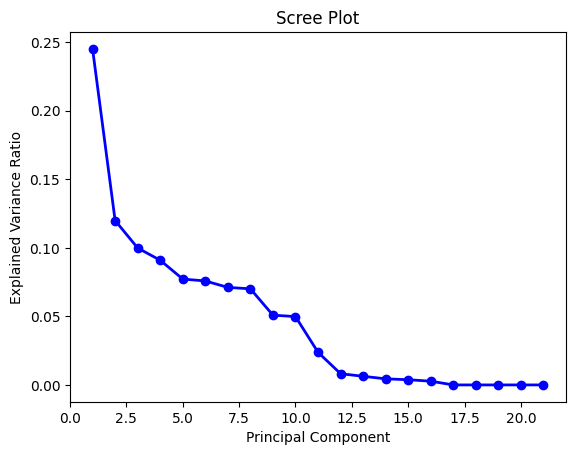


 Number of components to keep: 10


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X_train.iloc[:, 23:])

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

# Elbow plot

plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 'bo-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

print(f'\n Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
pca_train = pca.fit_transform(X_train.iloc[:, 23:])
pca_test = pca.transform(X_test.iloc[:, 23:])

In [ ]:
onehot_data_train = X_train.iloc[:, :23]
onehot_data_test = X_test.iloc[:, :23]

In [ ]:
X_train = pd.concat([pd.DataFrame(pca_train), pd.DataFrame(onehot_data_train)], axis=1)
X_test = pd.concat([pd.DataFrame(pca_test), pd.DataFrame(onehot_data_test)], axis=1)

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Models

In [ ]:
'''from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/rf.pkl', 'wb') as file:
    pickle.dump(model, file)'''

"from sklearn.ensemble import RandomForestClassifier\n\nmodel = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4)\n\nmodel.fit(X_train, y_train)\n\nwith open('/content/drive/MyDrive/University/Deloitte/model_fraud/rf.pkl', 'wb') as file:\n    pickle.dump(model, file)"

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/rf.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

RandomForestClassifier(class_weight='balanced', max_depth=4)
Confusion Matrix
 [[  812     0     0]
 [ 3636 24653     0]
 [  744  2303  3954]] 

Recalls [1.         0.87146948 0.56477646]
Precisions [0.15639445 0.91456448 1.        ]


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

model = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4), n_estimators=100)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/bagging.pkl', 'wb') as file:
    pickle.dump(model, file)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('bagging.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

FileNotFoundError: ignored

In [ ]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

model_voting = VotingClassifier(estimators=[], voting='hard')

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/voting.pkl', 'wb') as file:
    pickle.dump(model_voting, file)

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=200, learning_rate=0.1)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/xgb.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/xgb.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4), n_estimators=100)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/ada.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/ada.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/cat.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/cat.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

In [ ]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=3, covariance_type='full', max_iter=100, random_state=0)

model.fit(X_train)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/gmm.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/gmm.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', max_iter=1000)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/lr.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/lr.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight='balanced', max_depth = 4)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/dt.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('/content/drive/MyDrive/University/Deloitte/model_fraud/dt.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

# Synthetic Data

In [ ]:
y_test.replace({0: 'Fraud', 1: 'Regular', 2: 'Suspected'}, inplace=True)

In [ ]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
test = pd.concat([X_test, y_test], axis=1)
test

In [ ]:
!pip install git+https://github.com/sdv-dev/CTGAN.git

In [ ]:
test.select_dtypes(exclude="number").columns.tolist()

In [ ]:
from ctgan import CTGAN
import pandas as pd

categoricals = test.select_dtypes(exclude="number").columns.tolist()


ctgan = CTGAN(epochs=10)
ctgan.fit(test[:-1], categoricals)

synthetic_data = ctgan.sample(len(test))

In [ ]:
import pandas as pd
from ctgan import CTGAN

categoricals = df.select_dtypes(exclude="number").columns.tolist()

# Fit CTGAN
ctgan = CTGAN(epochs=10, batch_size=32)
ctgan.fit(df, categoricals)

# Generate the data
synthetic = ctgan.sample(20000)
synthetic.head()

In [ ]:
from sklearn.model_selection import train_test_split  

X = synthetic.drop(['Category'], axis=1) #Not scaled
y = synthetic['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

from sklearn.preprocessing import StandardScaler

s = StandardScaler()

X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X_train)

# Create a scree plot
num_components = len(pca.explained_variance_ratio_)
plt.plot(np.arange(1, num_components+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

print(f'\n Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
# Plot the cumulative variance explained

fig = plt.figure(figsize=(10, 5))

cum = np.insert(cumulative_variance_ratio, 0, 0)
ylab = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

plt.plot(cum, 'ro-', linewidth=2)
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.yticks(ylab)
plt.xticks(np.arange(0, 21))
plt.show()